# Food For Thought 
## Digging into the dataset

The first step of this project aims at understanding the dataset we have chosen ([Open Food Facts Database](https://world.openfoodfacts.org/)), to check whether it is suitable for the kind of analysis we want to develop.

As a reminder, we would like to focus our research on two main topics:
1. Impact of food on environment
2. Impact of food on the health

In [60]:
import re
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.mplot3d import Axes3D
from difflib import get_close_matches

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import findspark
findspark.init()

from pyspark.sql import *

import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
%matplotlib inline


In [2]:
# functions to save and load intermediate results in pickle format
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

In [3]:
spark

We set some basic plot properties with seaborn

In [4]:
style.use('seaborn-notebook') #sets the size of the charts
style.use('ggplot')

As a first operation, we load our dataset in .csv format. The separator of each field is a tab (\t)

In [5]:
DATA_FOLDER = './data/'
data = spark.read.csv(DATA_FOLDER +'en.openfoodfacts.org.products.csv',header=True,sep='\t')          

In [6]:
number_of_products = data.select('code').count()
number_of_products

685395

There are about 700k products in the dataset, with the following features:

In [7]:
data.columns

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_

### Missing values

Despite the large number of features, we need to check how many values are missing for each of them. Note that the dataset is mostly curated on a volunteer basis (each user can add product information), hence we expect to have many missing values, especially for the less common columns. 

In order to verify that, we count the missing values in each column and we convert the result to a Pandas dataframe, for plotting ease. The missing values are plotted in proportion of the total number of products. 

In [8]:
missing_data_count = data.select([F.count(F.when(data[c].isNull(),c)).alias(c) \
                                  for c in data.columns]).toPandas()

missing_data_count = missing_data_count * 100 / number_of_products #in percent

missing_data_count = missing_data_count.transpose().sort_values(by = 0, axis = 0).rename(columns = {0:'missing'})
missing_data_count.tail()

,missing
-nervonic-acid_100g,99.999854
ingredients_from_palm_oil,100.000000
ingredients_that_may_be_from_palm_oil,100.000000
cities,100.000000
nutrition_grade_uk,100.000000


We already notice that some of the columns have completely missing values (100 % of the products). To better visualize the rest, we use a bar chart. Since the number of features is high, we only show in the plot the features who have less then 80% missing values. Those features can be better used for the analysis.

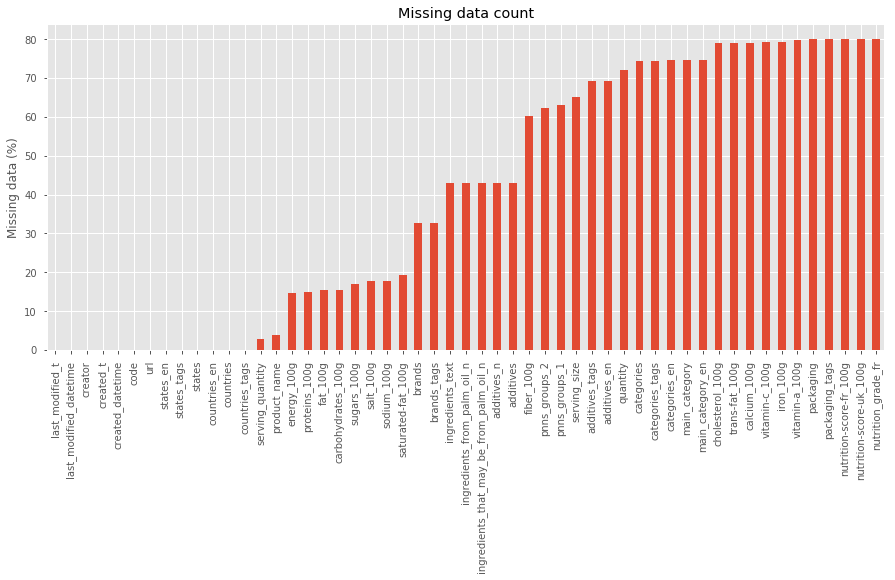

In [9]:
thresh = 80

missing_data_count[missing_data_count['missing'] < thresh].plot(kind = 'bar',figsize=(15, 6), legend="")

plt.ylabel('Missing data (%)')
plt.title('Missing data count')
plt.show()

As expected, most of the columns have a large number of missing values. Luckily enough, basic nutrition information (such as energy per 100g, proteins per 100g and so on) have less than 20% missing values. As long as we will work with single variables, the missing values will not compromise our analysis, as we will simply handle a smaller sample (hence we will have a smaller statistical power). The real problem could arise when we will use multiple variables together, as we will have to use only those products that have non-missing values for all the considered columns. For some columns, it could be possible to fill some of the missing gaps by knowledge of the relationship with other columns (e.g.:  if we have information about energy_100g, fat_100g, protein_100g, we can reconstruct the value of carbohydrates_100g as it is connected with all the others). However, this is not possible in general (e.g. with columns like packaging).

### Country distribution

Another important initial aspect to evaluate are the countries for which we have data available. In fact, the Open Food Facts project started in France, hence we expect to have a larger number of products coming from this country. At the same time, this kind of information allows us to understand the scopes of our research (i.e. how much it can be generalized).

In [10]:
country_value = data.groupby('countries_en').count().toPandas()
country_value = country_value.sort_values(by = 'count', ascending = False)
country_value.head()

,countries_en,count
207,France,413107
398,United States,173495
957,Switzerland,13533
156,Germany,11681
566,Spain,6104


We plot the number of products for the first 5 countries.

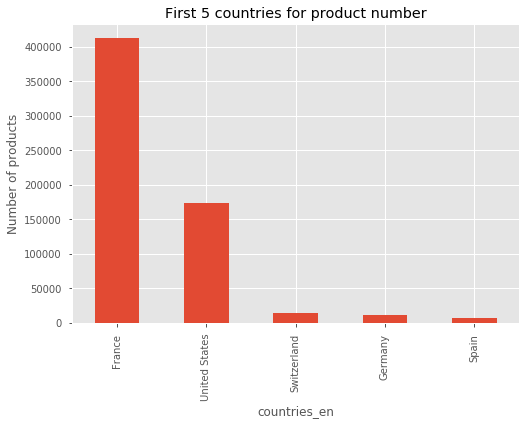

In [11]:
country_value.iloc[0:5,:].plot(kind = 'bar',x = 'countries_en', legend = '')
plt.title('First 5 countries for product number')
plt.ylabel('Number of products')
plt.show()

In [17]:
N_fr = country_value.iloc[0]
N_us = country_value.iloc[1]

print("number of products sold in France: ", N_fr.values[1])
print("number of products sold in the United States: ", N_us.values[1])

number of products sold in France:  413107
number of products sold in the United States:  173495


We can see that the large majority of the products come from France, so our analysis will mostly focus on that country. In case we will do a comparison among countries, we will be careful with our conclusions (since the dishomogeneity in the dataset could lead to bias). Note that some countries' name appear concatenated in the country_en column (like "Germany,Spain"). For now, we will not handle these cases, since they are a minority compared to the France and US data.

### Food categories healthiness

Now that we have analyzed our dataset in general, we will focus more on some specific features of interest. In particular, we will handle subsets of the original dataframe on which we conduct our processing.
One of this subset contains the basic nutritional features (energy, protein, fat, carbohydrates, sugar, salt and sodium content) along with the categorization done by PNNS ([Programme national nutrition santé](http://www.mangerbouger.fr/PNNS)). The PNNS categorizes food products in 9 groups. We want to understand whether the nutritional basic infos are able to discriminate among these groups. In that case, we will be able to categorize the other products of the dataset (that do not fall in one of the pnns_groups) and also get an idea of the healthiness of the category. On the other side, a negative results on this will indicate us that more features are needed to determine the categorization of a product.  

We select only the column of interest mentioned above, and we drop the rows that either have a null pnns value or an 'unknown' one.

In [18]:
columns = ["pnns_groups_1","energy_100g","fat_100g","sugars_100g",\
                       "proteins_100g","carbohydrates_100g","sodium_100g",\
                       "salt_100g","product_name"]
data_nutri = data.select(columns)

# cleaning the categories by removing null values and the unknown pnns_group
data_nutri = data_nutri.where(data.pnns_groups_1.isNotNull()).filter(data.pnns_groups_1!='unknown')

We then observe the unique values that pnns_groups has:

In [19]:
data_nutri.select('pnns_groups_1').distinct().collect()

[Row(pnns_groups_1='salty-snacks'),
 Row(pnns_groups_1='Cereals and potatoes'),
 Row(pnns_groups_1='cereals-and-potatoes'),
 Row(pnns_groups_1='Fat and sauces'),
 Row(pnns_groups_1='fruits-and-vegetables'),
 Row(pnns_groups_1='sugary-snacks'),
 Row(pnns_groups_1='Beverages'),
 Row(pnns_groups_1='Sugary snacks'),
 Row(pnns_groups_1='Fruits and vegetables'),
 Row(pnns_groups_1='Composite foods'),
 Row(pnns_groups_1='Salty snacks'),
 Row(pnns_groups_1='Fish Meat Eggs'),
 Row(pnns_groups_1='Milk and dairy products')]

Looking at the unique values of the pnns_group1 we can observe that we can shorten some categories that contain the same name: salty-snacks, cereals and potatoes, fruits and vegetables. We need to merge them in the same category.

In [20]:
# substitute - with a blank space
data_nutri=data_nutri.withColumn('pnns_groups_1',(F.regexp_replace('pnns_groups_1', '-', ' ')))

# convert all the categories names to have initial capital letter
square_udf_int = F.udf(lambda z: z.title())

data_nutri = data_nutri.withColumn('pnns_groups_1',square_udf_int('pnns_groups_1'))
data_nutri.select('pnns_groups_1').distinct().collect()

[Row(pnns_groups_1='Cereals And Potatoes'),
 Row(pnns_groups_1='Composite Foods'),
 Row(pnns_groups_1='Sugary Snacks'),
 Row(pnns_groups_1='Beverages'),
 Row(pnns_groups_1='Fat And Sauces'),
 Row(pnns_groups_1='Fruits And Vegetables'),
 Row(pnns_groups_1='Milk And Dairy Products'),
 Row(pnns_groups_1='Fish Meat Eggs'),
 Row(pnns_groups_1='Salty Snacks')]

In [21]:
data_nutri.count()

130621

Now we have the 9 categories as originally intended. Since we have only 130k products and a few columns, we can pass the data to Pandas for further processing.

In [22]:
data_nutri_pd = data_nutri.toPandas()

In [23]:
numeric_columns = ['energy_100g','fat_100g','carbohydrates_100g',\
                   'sugars_100g','proteins_100g',"sodium_100g","salt_100g"]

data_nutri_pd[numeric_columns] = data_nutri_pd[numeric_columns].apply(pd.to_numeric)

In [24]:
data_nutri_pd.head()

,pnns_groups_1,energy_100g,fat_100g,sugars_100g,proteins_100g,carbohydrates_100g,sodium_100g,salt_100g,product_name
0,Fruits And Vegetables,657.0,0.0,27.0,0.6,36.0,0.000000,0.000,Compote de poire
1,Cereals And Potatoes,669.0,2.2,0.6,9.5,25.2,0.140945,0.358,BAguette bressan
2,Fish Meat Eggs,1059.0,17.0,0.5,23.0,0.5,0.984252,2.500,Pavé de saumon fumé à la ficelle
3,Composite Foods,450.0,2.2,0.5,6.8,15.3,0.275591,0.700,Blanquette de Volaille et son Riz
4,Composite Foods,455.0,4.2,1.4,4.4,12.5,0.236220,0.600,Raviolini au Fromage de chèvre et Pesto


We compute the correlation matrix for the numeric features, not discriminated by category. 

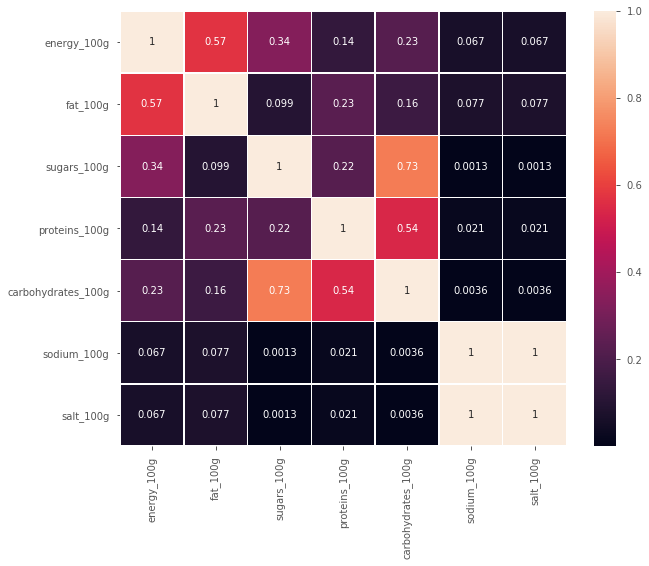

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(data_nutri_pd.corr(), annot = True, linewidths=.5)
plt.show()


We can observe that, expectedly, some columns are well correlated (e.g. sugars and carbohydrates) while others have mmuch lower correlation. One thing it's worth noticing. Sodium and salt have exactly 1 as correlation value. Hence, the two columns are the same and we should only consider one of them.

In [26]:
data_nutri_pd = data_nutri_pd.drop(columns = 'sodium_100g')

For the sake of visualization, we show the scatterplot of two variables divided by category. This could give us further insights on the data.

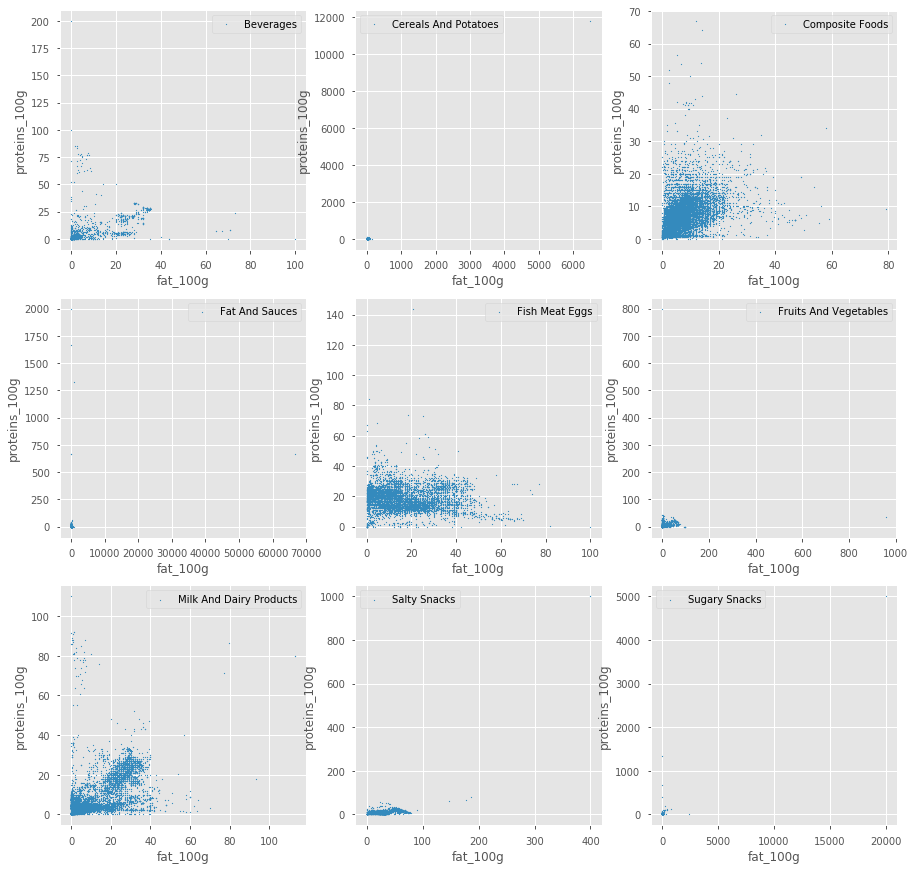

In [27]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

for i, (name, group) in enumerate(data_nutri_pd.groupby('pnns_groups_1')):
    
    group.plot(kind='scatter',x='fat_100g',y='proteins_100g',ax=ax[i // 3][i % 3],label=name, s = 0.5)
    
plt.show()    

We can see two interesting things: there are outliers that have unrealistic values (the fat in 100g of products cannot be more than 100g) and each category of food has a different correleration. Hence, we proceed at cleaning the impossible values with the following rule: for nutrients no values should overcome 100 (as discussed for the fat). For energy (that is measured in kJ) the value should not overcome 5000 (supposing each g of fat brings 9 kcal, 100g fats would bring 900 kcal, that are approximately 5000 kJ). We also drop columns containing nan values as they would be not considered in the analysis.

In [28]:
#constrain the data : energy<5000 and fat<100

def filterData(data,ParameterEnergy,Parameter):
    columns=data.filter(regex='_100g').columns
    for i in columns:
        if i=='energy_100g':
            data[i]=data[i][data[i]<ParameterEnergy]
        else:
            data[i]=data[i][data[i]<Parameter]
    return data


data_nutri_pd = filterData(data_nutri_pd,5000,100).dropna() 

We plot again the correlation heatmap, without outliers. We do it directly divided in categories

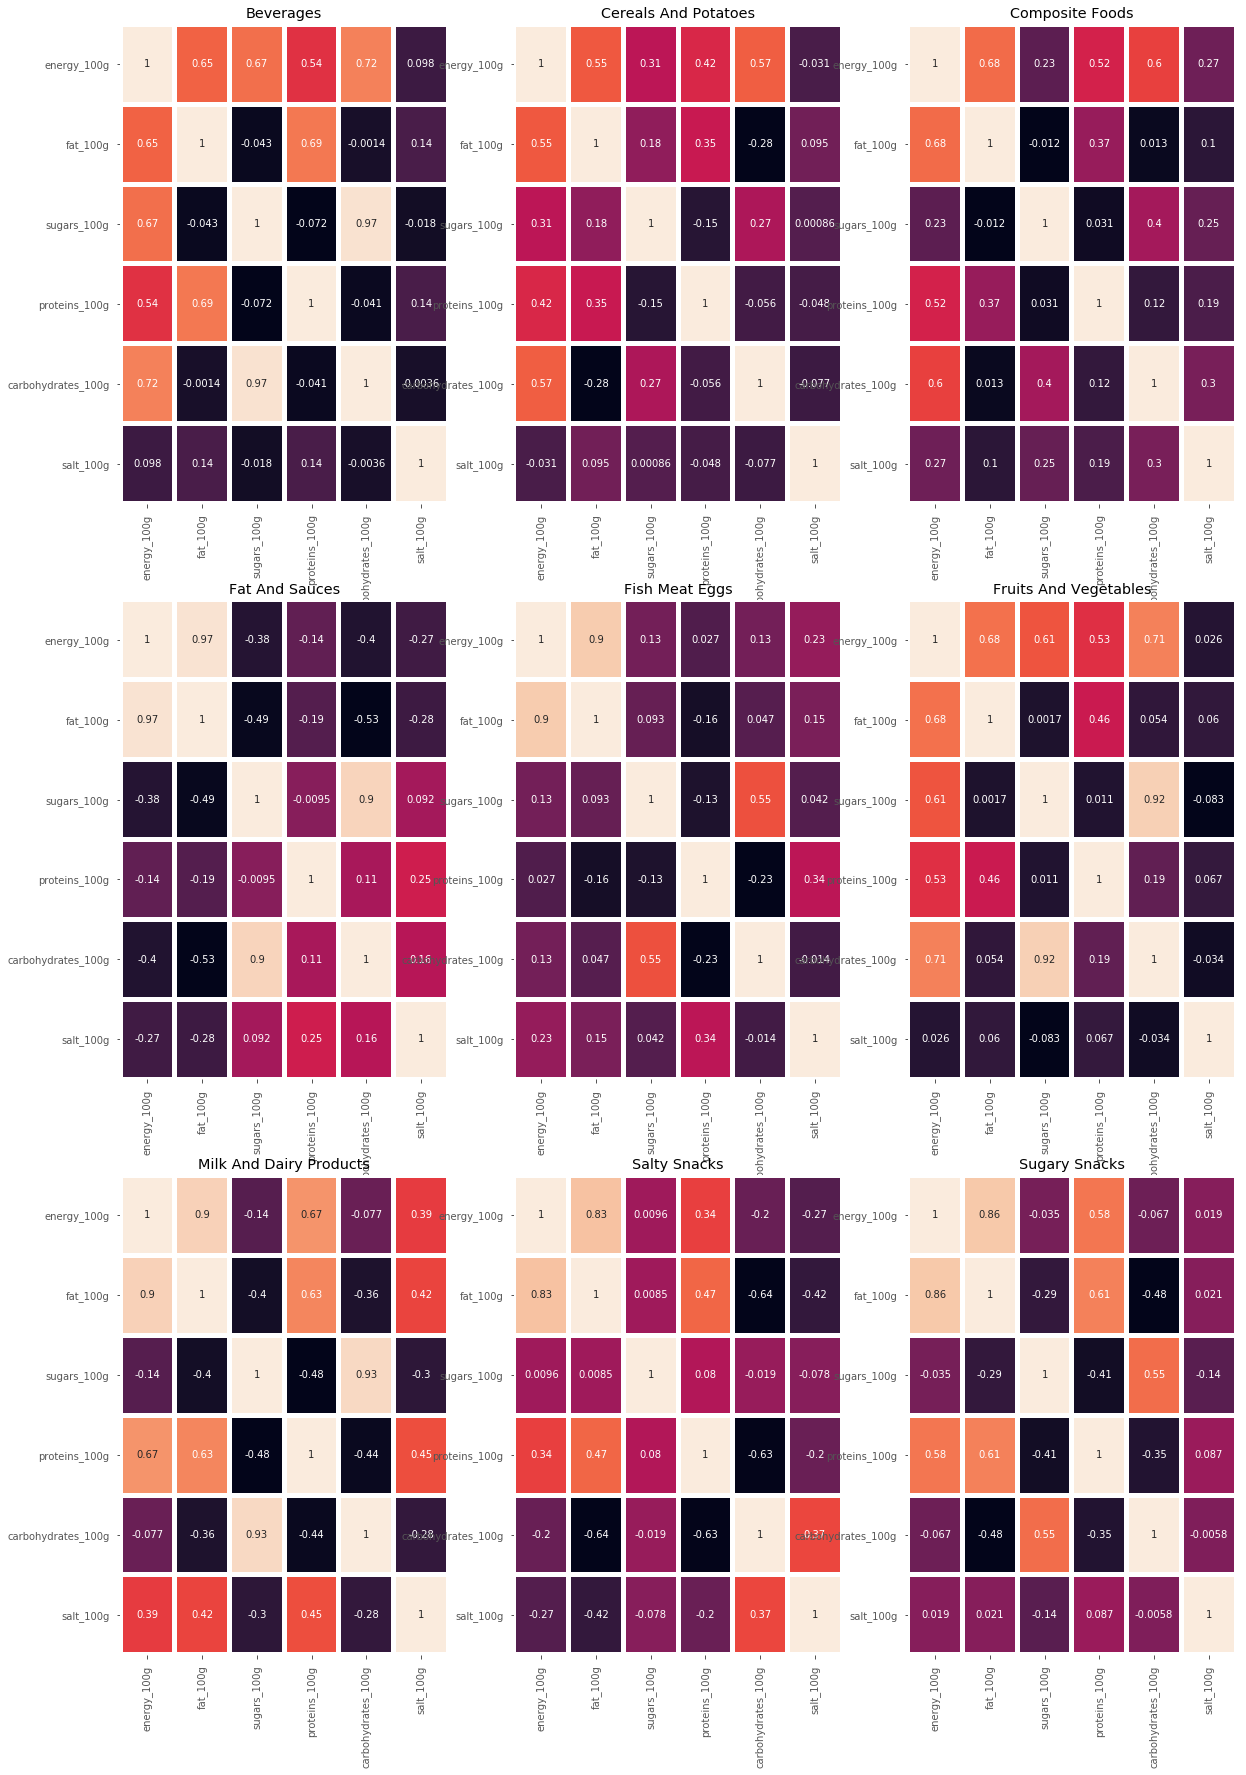

In [29]:
fig,ax = plt.subplots(3,3,figsize=(20,30))

for i, (name, group) in enumerate(data_nutri_pd.groupby('pnns_groups_1')):
    plt.subplot(3,3,i+1)
    sns.heatmap(group.corr(), annot = True,  linewidths=4, cbar = False)
    plt.title(name)

plt.show()

We can see that some of the categories share similar values of correlations, while other have completely different patterns (e.g. "Fat and sauces" and "Fruits and Vegetables" have opposite sign in some of the correlations values). We show this difference for the exemplar features "sugars_100g" and "energy_100g".

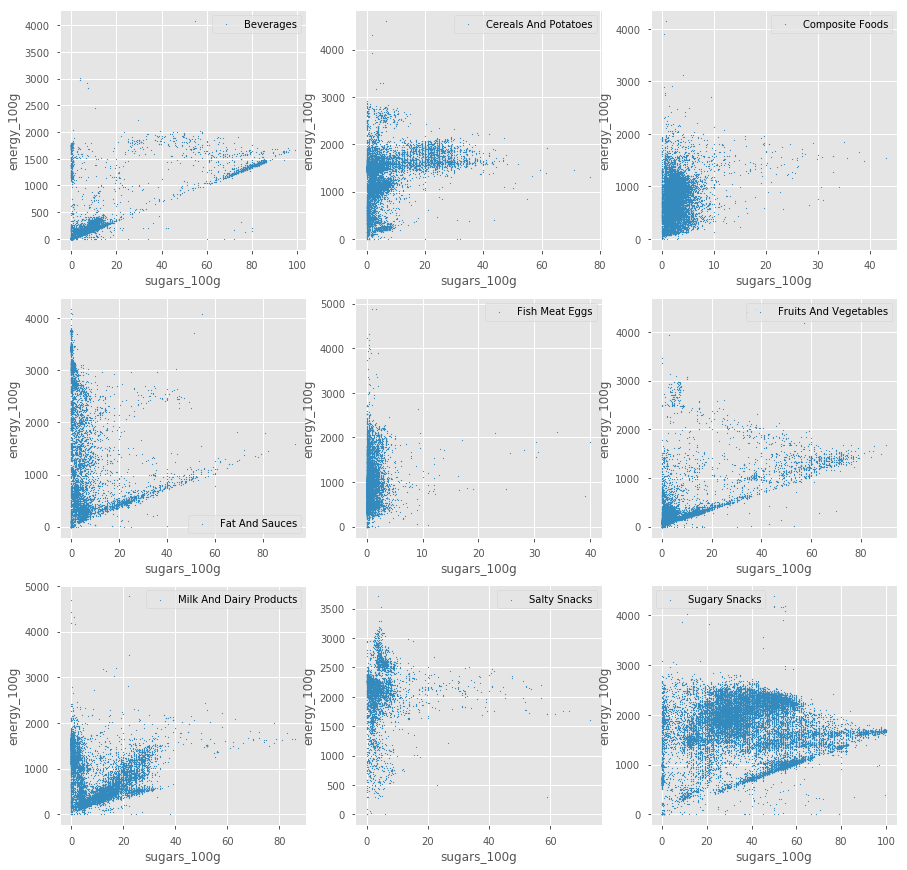

In [30]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

for i, (name, group) in enumerate(data_nutri_pd.groupby('pnns_groups_1')):
    
    group.plot(kind='scatter',x='sugars_100g',y='energy_100g',ax=ax[i // 3][i % 3],label=name, s = 0.5)
    
plt.show()   

We now visualize the distribution of one single column along categories, to check the separability of the classes. We chose 'fat_100g' for the visualization.

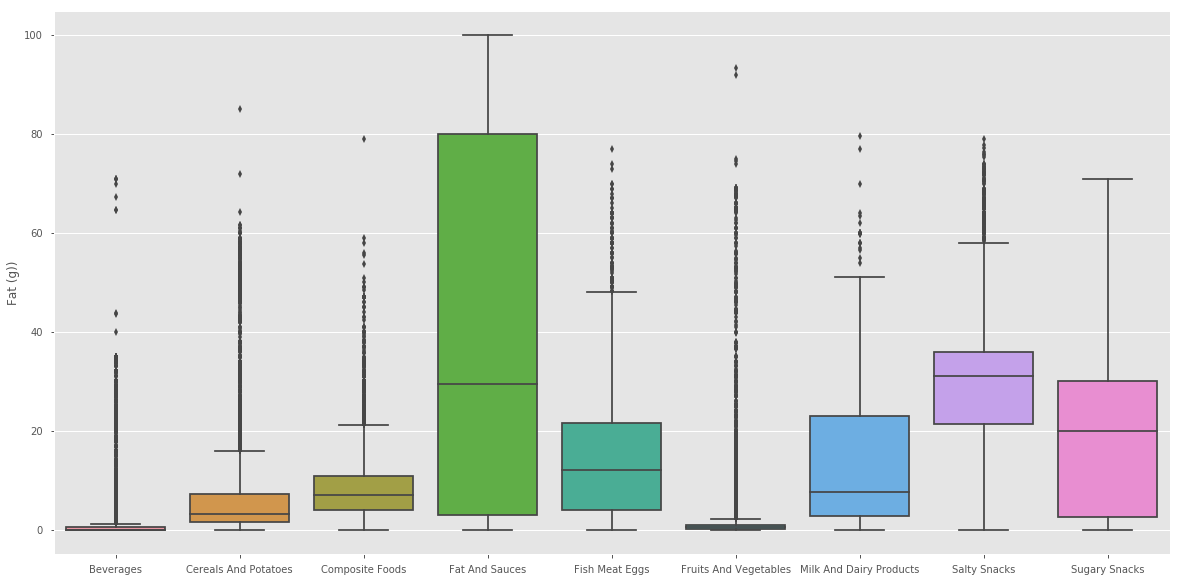

In [31]:
fig,ax=plt.subplots(figsize=(20,10))
nutri = []
for i, (name, group) in enumerate(data_nutri_pd[['pnns_groups_1','fat_100g']].groupby('pnns_groups_1')):
    nutri.append(group['fat_100g'].values)
    
nutri=np.asarray(nutri)    
g=sns.boxplot(data= nutri)
plt.xticks(plt.xticks()[0],sorted(data_nutri_pd.pnns_groups_1.unique()))

plt.ylabel('Fat (g))')
plt.show()

The classes show different distributions for this features, suggesting there could be a good separability when using more features. To analyze the categorization of the data with all the features and visualize it, we decide to perform a PCA and retain the first three principal components.

In [32]:
# prepare the dataset
X=data_nutri_pd.iloc[:,1:7].values
y=data_nutri_pd.iloc[:,0].values#LABELS

#standardize values
X_std = StandardScaler().fit_transform(X)

#compute pca
pca = PCA(n_components=3)
Y = pca.fit_transform(X_std)

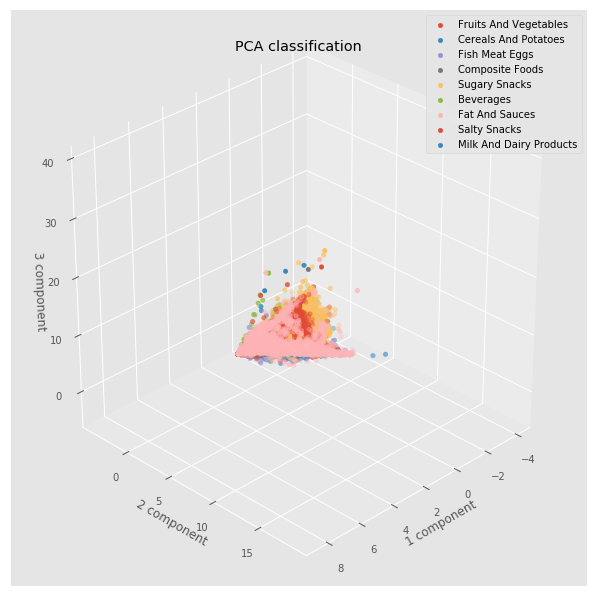

In [33]:
fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig)

for name in data_nutri_pd.pnns_groups_1.unique():
        ax.scatter( 
            Y[y==name,0],\
            Y[y==name,1],\
            Y[y==name,2],
            label=name)
        
plt.legend()
plt.title('PCA classification')
plt.xlabel('1 component')
plt.ylabel('2 component')
ax.set_zlabel('3 component')

ax.view_init(30, 45)
    
plt.show()

Despite our first clues, the representation in the first 3 principal components does not seem to yield good clustering performances. We will further investigate this phenomenon (for example by removing extreme values and check the explained variance and PC loadings) to check whether a good categorization can be achieved. From there, we will extend the categorization of PNNS to the other products. When the final food score will be computed, this categorization will be the basis for our food selector. 

### Brand vs Nutrition

In this part we investigate the nutrition score of the products in the whole dataset and with respect to each brand. 

In [36]:
data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in ['brands']]).show()

+------+
|brands|
+------+
|224276|
+------+



There are 224,276 products over the 685,395 without any brand tag. We remove them, assuming the statistics does not change (very low number). We also remove the products with a null 'countries_en' tag. 

In [37]:
data_brands_countries = data.na.drop(subset=['brands', 'countries_en'])

In [38]:
data_brands_countries.count()

460800

There are 460,800 products with a non-null 'brands' tag and non-null 'countries_en' tag (=country in which the product is sold).

In [39]:
# we extract the products sold both in the United States and in France.
data_us_and_fr = data_brands_countries.rdd.filter(lambda r: re.match('(?=.*united State)(?=.*france)', r['countries_en'], flags=re.IGNORECASE)).toDF(schema=data.schema)
count = data_us_and_fr.groupby('brands').count()

In [40]:
print("There are", count.count(), "brands present both in the US and in France.")

There are 1107 brands present both in the US and in France.


In [41]:
# here is the products sold both in the US and in France. There are mainly american brands. 
count.orderBy('count',ascending=False).show()

+--------------------+-----+
|              brands|count|
+--------------------+-----+
|        Trader Joe's|   27|
|         Lee Kum Kee|   13|
|       Nature's Path|   12|
|              Skippy|   10|
|           Kellogg's|    9|
|Foco,  Thai Agri ...|    8|
|Arizona,  Ferolit...|    8|
|         Great Value|    8|
|               Kraft|    7|
|           Hershey's|    6|
|     Lenny & Larry's|    6|
|  Kirkland Signature|    6|
|                Foco|    6|
|                Kind|    6|
|     Pepperidge Farm|    6|
|             Walkers|    5|
|  365 Everyday Value|    5|
|                 S&B|    5|
|           Starbucks|    5|
|       Nature Valley|    5|
+--------------------+-----+
only showing top 20 rows



In the present dataset there are a very few brands sold both in the United States and in France. 

In [42]:
# here we extract the product sold only in the United States.
data_us_only = data_brands_countries.select('brands', 
            'countries_en',
            'nutrition-score-fr_100g',
            'nutrition-score-uk_100g',
            'nutrition_grade_fr',
            'nutrition_grade_uk') \
.filter("countries_en=='United States'")

In [44]:
# here we see if there are non-null nutrition scores for a large enough number of products.
data_us_only.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in \
           ['nutrition-score-fr_100g',
            'nutrition-score-uk_100g',
            'nutrition_grade_fr',
            'nutrition_grade_uk']]).show()

+-----------------------+-----------------------+------------------+------------------+
|nutrition-score-fr_100g|nutrition-score-uk_100g|nutrition_grade_fr|nutrition_grade_uk|
+-----------------------+-----------------------+------------------+------------------+
|                 169380|                 169380|            169380|            171384|
+-----------------------+-----------------------+------------------+------------------+



In [47]:
print("number of products sold in the US with a non-null nutrition score:", N_us.values[1] - 171513)
print("ratio among the total number of products sold in the US:", (N_us.values[1] - 171513)/N_us.values[1]*100)

number of products sold in the US with a non-null nutrition score: 1982
ratio among the total number of products sold in the US: 1.142396034467852


Only 1982 products sold in the United States have a nutrition score... We cannot do a statistically significant nutrition analysis on the set of products sold in the US when only 1.14% of the product are annotated with a nutrition score.

In [48]:
# here we extract the products sold only in France.
data_fr_only = data_brands_countries.select('brands', 
            'countries_en',
            'nutrition-score-fr_100g',
            'nutrition-score-uk_100g',
            'nutrition_grade_fr',
            'nutrition_grade_uk') \
.filter("countries_en=='France'")

In [49]:
# number of products sold only in France.
data_fr_only.count()

217393

In [52]:
# here we see if there are non-null nutrition scores for a large enough number of products.
data_fr_only.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in \
           ['nutrition-score-fr_100g',
            'nutrition-score-uk_100g',
            'nutrition_grade_fr',
            'nutrition_grade_uk']]).show()

+-----------------------+-----------------------+------------------+------------------+
|nutrition-score-fr_100g|nutrition-score-uk_100g|nutrition_grade_fr|nutrition_grade_uk|
+-----------------------+-----------------------+------------------+------------------+
|                 116825|                 116825|            116825|            217393|
+-----------------------+-----------------------+------------------+------------------+



Among the 217,393 products sold in France with a non-null brand there are 101,289 (=218,114 -116,825) products with a nutrition score. We are going to focus the analysis "nutrition vs brand" on the products sold only in France and using the french nutrition grade.   

### Brand vs Nutrition in France 

In [53]:
# we remove the products which have no 'brands' and no 'nutrition_grade_fr' tags.
data_brand_nutrition = data.na.drop(subset=['brands', 'nutrition_grade_fr'])

In [54]:
# we extract the products sold only in France
data_fr_only = data_brand_nutrition.filter("countries_en=='France'")

In [55]:
# we reduce the dataframe to the columns of interest
brand = data_fr_only.select('brands', 'nutrition_grade_fr')

In [57]:
# we convert the spark dataframe to a pandas dataframe
#brand_df = brand.toPandas()

# we store it in the current folder 
#brand_df.to_pickle('brand_vs_nutrition_in_France_df')

In [58]:
# we can now read it everytime we want to continue the analysis
brand_df = pd.read_pickle('brand_vs_nutrition_in_France_df')

The problem is that the 'brands' tags are not always consistent. For example we can find the brand tag 'carrefour', "Carrefour", "carrfour,bio carrefour' ect. 
Hence we first clean the brands using a list of food brands present in France and a function to match the 'brands' tag with the closest brand in the list. 

In [59]:
# list of food brands present in France ('Coca Cola', 'Fleury Michon', 'Carrefour' ect.)
list_brand_file = open("brand_list.txt", "r")
list_brand = list_brand_file.read().split('\n')

# Function which find for each value (string) in the column 'brands' the closest brand (string) in 'list_brand'.
# Note: the function 'get_close_matches' has been imported from the open-source 'difflib' library.
def clean_brand(brand_name):
    
    # brand name can be of the form 'Carrefour' (one word) or 'Carrefour, Bio Carrefour' (multiple words)
    # hence we split the string w.r.t the symbol ',' and find the best matching brand word for each split.
    best=[]
    for word in brand_name.split(','):
        
        # the cutoff control for the False Positives possibilities in the 'list_brand' 
        # that don’t score at least the cutoff are ignored.
        # n controls for the the number of possibilities (whose score is higher than the cutoff value).
        best.append(get_close_matches(word, list_brand, n=1, cutoff=0.7))
    
    # remove empty sublists and unravel
    best = [brand for sublist in best for brand in sublist if sublist]
    
    # if there was 
    if best:
        return best[0]
    else:
        return None


In [61]:
# we create a new column with the new "consistent" brand tag. 
# takes some minutes to run...
brand_df['new_brands'] = brand_df['brands'].apply(lambda x: clean_brand(x))

In [62]:
# we can drop the old column 'brands' since we have the new ones.
brand_df_cleaned = brand_df.dropna().drop('brands',1).rename(columns={'new_brands':'brands'})
brand_df_cleaned.head()

,nutrition_grade_fr,brands
0,d,Crous
1,a,Crous
3,b,Comme J'aime
4,b,Comme J'aime
8,c,Alice Délice


In [63]:
# here we count the number of products for each brand. We consider that brand have enough products to be analyzed from 100 products
brand_count = brand_df_cleaned.groupby('brands').count().sort_values('nutrition_grade_fr', ascending=False)
brand_count['enough_products']= brand_count.apply(lambda x: x>100)
brand_count = brand_count[brand_count.enough_products]
brand_count.head(5)

,nutrition_grade_fr,enough_products
brands,,
Carrefour,3635,True
Auchan,3567,True
U,3276,True
Marque Repère,2463,True
Casino,2162,True


The most abundant brands are Carrefour, Auchan and U. There are the brands of the biggest distributors (supermarkets) in France. 

In [65]:
# here we add the column "enough products" to the dataframe with the cleaned brand.
brand = brand_df_cleaned.join(brand_count[['enough_products']], on='brands')
brand = brand.dropna().drop('enough_products',1)
brand.head()

,nutrition_grade_fr,brands
14,d,Heinz
15,e,Coca Cola
21,d,Heinz
32,e,Marks & Spencer
33,e,Marks & Spencer


In [66]:
# here we create dummy variables from the 'nutrition_grade_fr' whose value can be:
# - 'a' (very good product for health) 
# - 'b' (good product)
# - 'c' ('neutral product')
# - 'd' ('not so good product')
# - 'e' (bad product for health)

brand_expanded = pd.get_dummies(brand.set_index('brands')).reset_index()
brand_expanded = brand_expanded.rename(columns={'nutrition_grade_fr_a':'a',
                               'nutrition_grade_fr_b':'b',
                               'nutrition_grade_fr_c':'c',
                               'nutrition_grade_fr_d':'d',
                               'nutrition_grade_fr_e':'e'})
brand_expanded.head(5)

,brands,a,b,c,d,e
0,Heinz,0,0,0,1,0
1,Coca Cola,0,0,0,0,1
2,Heinz,0,0,0,1,0
3,Marks & Spencer,0,0,0,0,1
4,Marks & Spencer,0,0,0,0,1


### Food quality in the whole dataset

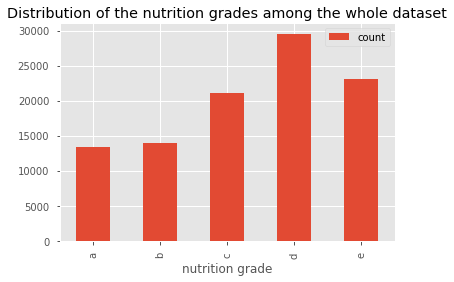

In [67]:
count = brand_df[['nutrition_grade_fr','brands']].groupby('nutrition_grade_fr').count().rename(columns={'brands':'count'})
count.plot(kind='bar')
plt.title('Distribution of the nutrition grades among the whole dataset')
plt.xlabel('nutrition grade') 
plt.show()

### Food quality for each brand

In [75]:
# extract the total number of products for each brands
brand_count = brand.groupby('brands').count().rename(columns={'nutrition_grade_fr':'total'})
brand_count.head()

,total
brands,
Amora,139
Andros,282
Auchan,3567
Belin,141
Belle France,1188


In [76]:
# here we count the nutrition grade occurences for each brand
brand_expanded_count = brand_expanded.groupby('brands').sum()
brand_expanded_count.head(3)

,a,b,c,d,e
brands,,,,,
Amora,1.0,3.0,23.0,90.0,22.0
Andros,117.0,13.0,84.0,37.0,31.0
Auchan,659.0,548.0,778.0,965.0,617.0


In [77]:
# we add the column total (with the total number of products sold for each brand) to further extract the ratio of each grade instead of the raw count.
brand_expanded_count = brand_expanded_count.join(brand_count)#.rename(columns = {'nutrition_grade_fr':'total'})
brand_expanded_count.head()

,a,b,c,d,e,total
brands,,,,,,
Amora,1.0,3.0,23.0,90.0,22.0,139
Andros,117.0,13.0,84.0,37.0,31.0,282
Auchan,659.0,548.0,778.0,965.0,617.0,3567
Belin,5.0,4.0,19.0,59.0,54.0,141
Belle France,194.0,154.0,251.0,356.0,233.0,1188


In [78]:
# we convert the counts into ratios. (ex: ratio for 'a' = count for 'a' / total number of products)
ratio = brand_expanded_count.copy()
ratio[['a','b','c','d','e']] = brand_expanded_count[['a','b','c','d','e']].div(brand_expanded_count['total'].values,axis=0)
ratio = ratio.sort_values('total',ascending=False)

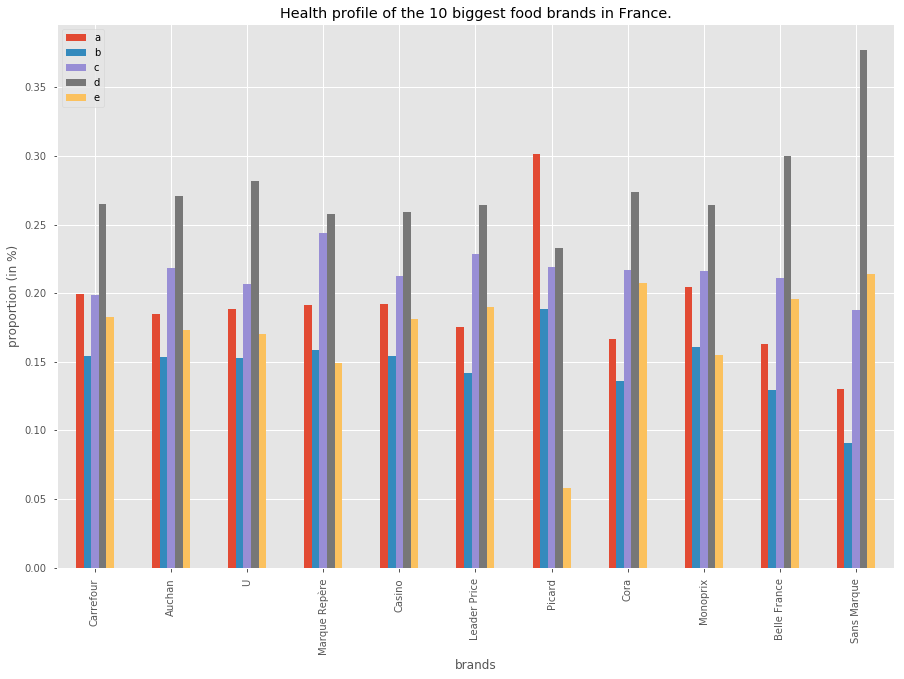

In [79]:
ratio.reset_index().loc[:10].drop('total',1).plot(kind='bar', x='brands',figsize=[15,10])
plt.ylabel('proportion (in %)')
plt.title('Health profile of the 10 biggest food brands in France.')
plt.show()

We tought we could reduce the number of possible scores to allow even simplier analysis. From the set of 5 grades (a,b,c,d,e) we go to a set of three grades:
- 'healthy' food if a or b grades
- 'neutral' food if c grade
- 'junk' food if d or e grades

In [80]:
# function to transform the scores contained in a row dataframe. 
def get_new_score(df_row):
    if df_row['a']==1 or df_row['b']==1:
        new_score = 'healthy' 
    if df_row['c']==1:
        new_score = 'neutral' 
    if df_row['d']==1 or df_row['e']==1:
        new_score = 'junk'
    return new_score

In [81]:
# here we pass for the "old" scores to the "new" ones
brand_with_new_score = brand_expanded.copy()

# we create a new column to store the "new" scores
brand_with_new_score['new_score'] = brand_expanded.apply(get_new_score, axis=1)

# we convert those "new" scores to dummy variables, as before for the "old" ones
brand_with_new_score = pd.get_dummies(brand_with_new_score[['brands','new_score']].set_index('brands')).reset_index()

# we rename the columns
brand_with_new_score = brand_with_new_score.rename(columns={'new_score_healthy':'healthy',
                                     'new_score_junk':'junk',
                                     'new_score_neutral':'neutral'})
brand_with_new_score.head()

,brands,healthy,junk,neutral
0,Heinz,0,1,0
1,Coca Cola,0,1,0
2,Heinz,0,1,0
3,Marks & Spencer,0,1,0
4,Marks & Spencer,0,1,0


In [82]:
# we can group the products by brands as before to get 
brand_with_new_score = brand_with_new_score.groupby('brands').sum()
brand_with_new_score.head(3)

,healthy,junk,neutral
brands,,,
Amora,4.0,112.0,23.0
Andros,130.0,68.0,84.0
Auchan,1207.0,1582.0,778.0


In [83]:
# we get the ratios instead of the raw counts, as before
brand_with_new_score = brand_with_new_score.join(brand_count)
ratio = brand_with_new_score.copy()
ratio[['healthy','neutral','junk']] = brand_with_new_score[['healthy','neutral','junk']].div(brand_with_new_score['total'].values,axis=0)
ratio = ratio.sort_values('total',ascending=False)

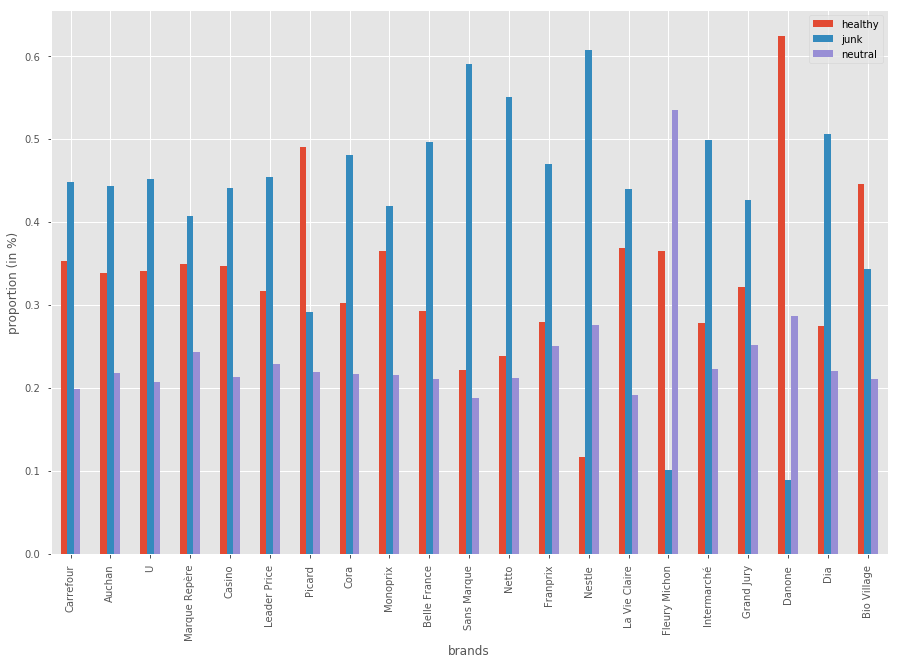

In [84]:
# final plot
ratio.reset_index().loc[:20].drop('total',1).plot(kind='bar', x='brands',figsize=[15,10])
plt.ylabel('proportion (in %)')
plt.show()

We observe for example that for almost all the biggest food brands present in France the prominent nutrition category is "junk" food. We don't eat that well in France... 

The two biggest exceptions are 'Danone' and 'Picard'. They mainly sell products from milk and frozen food which could be excpected to be healthier than the products sold by Fleury Michon (mainly transformed products from meat).  

Interestingly the 'Bio Village' brand solds a lot of 'junk' food... Even more than 'neutral' food.